# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal
### Projet A2024
----
Équipe T - TODO
### Objectif
Prédiction de **la consommation en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [331]:
# import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree")

   Resolving package versions...
  No Changes to `C:\Users\Carl-Éric\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Carl-Éric\.julia\environments\v1.10\Manifest.toml`


In [332]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree, Random, Plots


In [333]:
function add_rows(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]
    return data
end

add_rows (generic function with 1 method)

In [334]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = add_rows(data_copy)
    return standardised_data
end




getStandardEncodedData (generic function with 1 method)

In [335]:
function decisionTree_remise(X_train ,y_train,  X_test, max_depth)
    model = DecisionTreeRegressor(max_depth=max_depth)
    fit!(model, X_train, y_train)
    ychap =  predict(model, X_test)  
    return ychap
end

decisionTree_remise (generic function with 1 method)

In [336]:
function format_file(predictions)
    println(predictions)
    current_time = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    file_name = "benchmark_" * current_time * ".csv"
    CSV.write("../../soumissions_potentielles/" *file_name, predictions)
end

format_file (generic function with 1 method)

In [337]:
COLUMNS_TO_COMPARE = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]

function get_unique_data(data)
    unique_data = combine(groupby(data, COLUMNS_TO_COMPARE), :consommation => mean, :annee => first)
    rename!(unique_data, :consommation_mean => :consommation)
    rename!(unique_data, :annee_first => :annee)
    return unique_data
end

function find_pairs(data_train, data_predict)
    train_data_without_consommation = select(data_train, Not(:consommation, :annee))
    predict_data_without_annee = select(data_predict, Not(:annee))

    common_values = innerjoin(data_train, predict_data_without_annee, on=names(train_data_without_consommation))

    return common_values
end

function find_differents(data_train, data_predict)
    different_values = antijoin(data_predict, data_train, on=COLUMNS_TO_COMPARE)
    return different_values
    
end

function predict_with_dups(data_train, data_predict, raw_train_data)
    pairs = find_pairs(data_train, data_predict)
    pairs = select(pairs, [:id, :consommation])

    # print(pairs)
    different_values = find_differents(data_train, data_predict)

    # trainDataStandard = getStandardEncodedData(data_train)
    
    raw_train_data[!,:volume_gaz] = raw_train_data[!,:nombre_cylindres] .* raw_train_data[!,:cylindree]
    different_values[!,:volume_gaz] = different_values[!,:nombre_cylindres] .* different_values[!,:cylindree]

    # X_train =  Matrix(trainData[:, Not(:consommation, :id)])
    # y_train = trainData.consommation

    # println(data_train)
    # println("X_train: ", trainData[:, Not(:consommation)])
    # println(data_train[:, Not(:consommation)])

    # X_test = Matrix(testData)


    X_train = Matrix(raw_train_data[:, Not(:consommation, :id)])
    y_train = raw_train_data.consommation
    

    X_test = Matrix(different_values[:, names(raw_train_data[:, Not(:consommation, :id)])])
    # X_test = Matrix(data_predict)
    # println(X_test)




    res =  decisionTree_remise(X_train ,y_train,  X_test, 5)

    prediction_differents = DataFrame(id=different_values.id, consommation=res)

    prediction = vcat(pairs, prediction_differents)
    prediction = sort(prediction, :id)

    return prediction
end
    

predict_with_dups (generic function with 2 methods)

In [338]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)




1:150

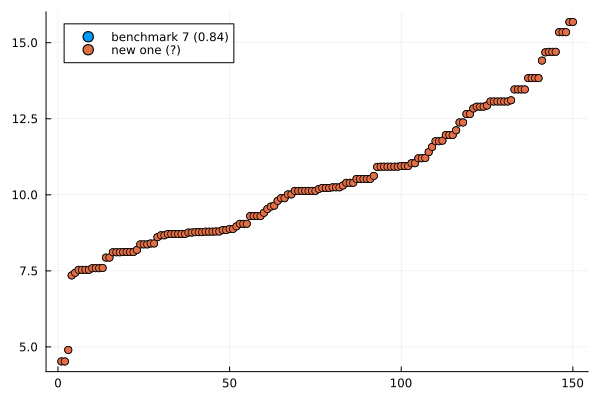

In [339]:
function main()
    # println(find_duplicates(trainData))
    uniqueD = get_unique_data(trainData)
    # find_pairs(uniqueD, testData)

    # print(uniqueD)
    # print(trainData[!, Not(:id, :annee)])

    # println(uniqueD)

    # format_file(predict_with_dups(uniqueD, testData, trainData))
   data_2 = predict_with_dups(uniqueD, testData, trainData)

   data_1 = CSV.read("../../soumissions_officielles/soumission_7/benchmark7.csv", DataFrame)


   common_ids = [1, 2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 113, 114, 116, 117, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
   
   data_1_common = filter(row -> row.id in common_ids, data_1)
   data_2_common = filter(row -> row.id in common_ids, data_2)
   
   
   data_1_sorted = sort(data_1, :consommation)
   data_2_sorted = [data_2.consommation[i] for i in data_1_sorted.id]
   
   
   
   scatter(1:150, data_1_sorted.consommation,  label="benchmark 7 (0.84)")
   scatter!(1:150, data_2_sorted, label= "new one (?)")



    # format_file(predict_with_dups(uniqueD, testData))
    # uniqueD[!,:volume_gaz] = uniqueD[!,:nombre_cylindres] .* uniqueD[!,:cylindree]
    # uniqueD
    
    # display(plot(x=uniqueD.cylindree, y=uniqueD.consommation, color=uniqueD.type))
    # scatter(uniqueD.volume_gaz, uniqueD.consommation, zcolor=uniqueD.type)
    # trainDataStandard = getStandardEncodedData(trainData)

    # predictDataStandard = getStandardEncodedData(testData)
    # evaluate_rmse(trainDataStandard)
    # forest_predict(trainDataStandard,predictDataStandard)
end
main()

## Exploration des données